<a href="https://colab.research.google.com/github/Rey-irl/Coffee-Plant-Nutritional-Deficiencies-Classification-Using-Transfer-Learning/blob/main/Data_preparation_ND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
7import os
import zipfile
import shutil
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, InceptionV3, MobileNetV2, InceptionResNetV2
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the path to the zip file and the extraction directory
local_zip = '/content/drive/MyDrive/RCP-CNN-1/CoLeaf.zip'
extract_dir = '/content/drive/MyDrive/RCP-CNN-1/CoLeaf'

# Function to check if the zip file is already extracted
def is_extracted(directory):
    # Check if the directory exists and contains any files
    return os.path.exists(directory) and len(os.listdir(directory)) > 0

# Check if the directory is already extracted
if not is_extracted(extract_dir):
    # If the directory is not extracted, extract the zip file
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall('/content/drive/MyDrive/RCP-CNN-1')
    print(f'Extracted to: {extract_dir}')
else:
    # If the directory already exists and is not empty, skip extraction
    print(f'The directory already exists: {extract_dir}')

# Define the base directory where the dataset was extracted
base_dir = extract_dir

# Print the contents of the base directory to verify extraction
print(f"Contents of the base directory ({base_dir}):")
print(os.listdir(base_dir))

Extracted to: /content/drive/MyDrive/RCP-CNN-1/CoLeaf
Contents of the base directory (/content/drive/MyDrive/RCP-CNN-1/CoLeaf):
['boron', 'calcium', 'healthy', 'iron', 'magnesium', 'manganese', 'nitrogen', 'others', 'phosphorus', 'potasium']


In [ ]:
# Define training and validation directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

categories = ['boron', 'calcium', 'healthy', 'iron', 'magnesium', 'manganese',
              'others', 'nitrogen', 'phosphorus', 'potasium']

files_dict = {category: set() for category in categories}

# Check if the category directories already exist in both 'train' and 'validation'
directories_exist = all(
    os.path.exists(os.path.join(train_dir, category)) and
    os.path.exists(os.path.join(validation_dir, category))
    for category in categories
)

# If directories don't exist, create them
if not directories_exist:
    for category in categories:
        train_category_dir = os.path.join(train_dir, category)
        validation_category_dir = os.path.join(validation_dir, category)
        os.makedirs(train_category_dir, exist_ok=True)
        os.makedirs(validation_category_dir, exist_ok=True)

# Walk through the base directory to find image files
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(('.jpg', '.png', '.jpeg','.JPG')):  # Add any other file extensions if needed
            file_path = os.path.join(root, file)
            for category in categories:
                if category in root.lower() and file_path not in files_dict[category]:
                    files_dict[category].add(file_path)
                    break

# Convert sets to lists for further processing
files_list_dict = {category: list(files_dict[category]) for category in categories}

# Print the number of files found in each category
for category in categories:
    print(f"Number of {category} files found: {len(files_list_dict[category])}")

Number of boron files found: 101
Number of calcium files found: 162
Number of healthy files found: 290
Number of iron files found: 65
Number of magnesium files found: 79
Number of manganese files found: 83
Number of others files found: 104
Number of nitrogen files found: 64
Number of phosphorus files found: 246
Number of potasium files found: 96


In [ ]:
# Function to split and copy files to training and validation directories
def split_and_copy_files(files, train_dir, validation_dir):
    # Split the files into 80% train and 20% validation
    train_files, validation_files = train_test_split(files, test_size=0.2, random_state=42)

    # Function to copy files to the target directory
    def copy_files(file_list, target_dir):
        for file_path in file_list:
            target_path = os.path.join(target_dir, os.path.basename(file_path))
            shutil.copy(file_path, target_path)

    # Copy training files
    copy_files(train_files, train_dir)
    # Copy validation files
    copy_files(validation_files, validation_dir)

# Iterate over each category and split the files
for category in categories:
    # Define the train and validation directories for the current category
    train_category_dir = os.path.join(train_dir, category)
    validation_category_dir = os.path.join(validation_dir, category)

    # Get the list of files for the current category
    category_files = files_list_dict[category]

    # Split and copy the files to their respective directories
    split_and_copy_files(category_files, train_category_dir, validation_category_dir)

print("Files have been successfully copied to training and validation directories.")

Files have been successfully copied to training and validation directories.


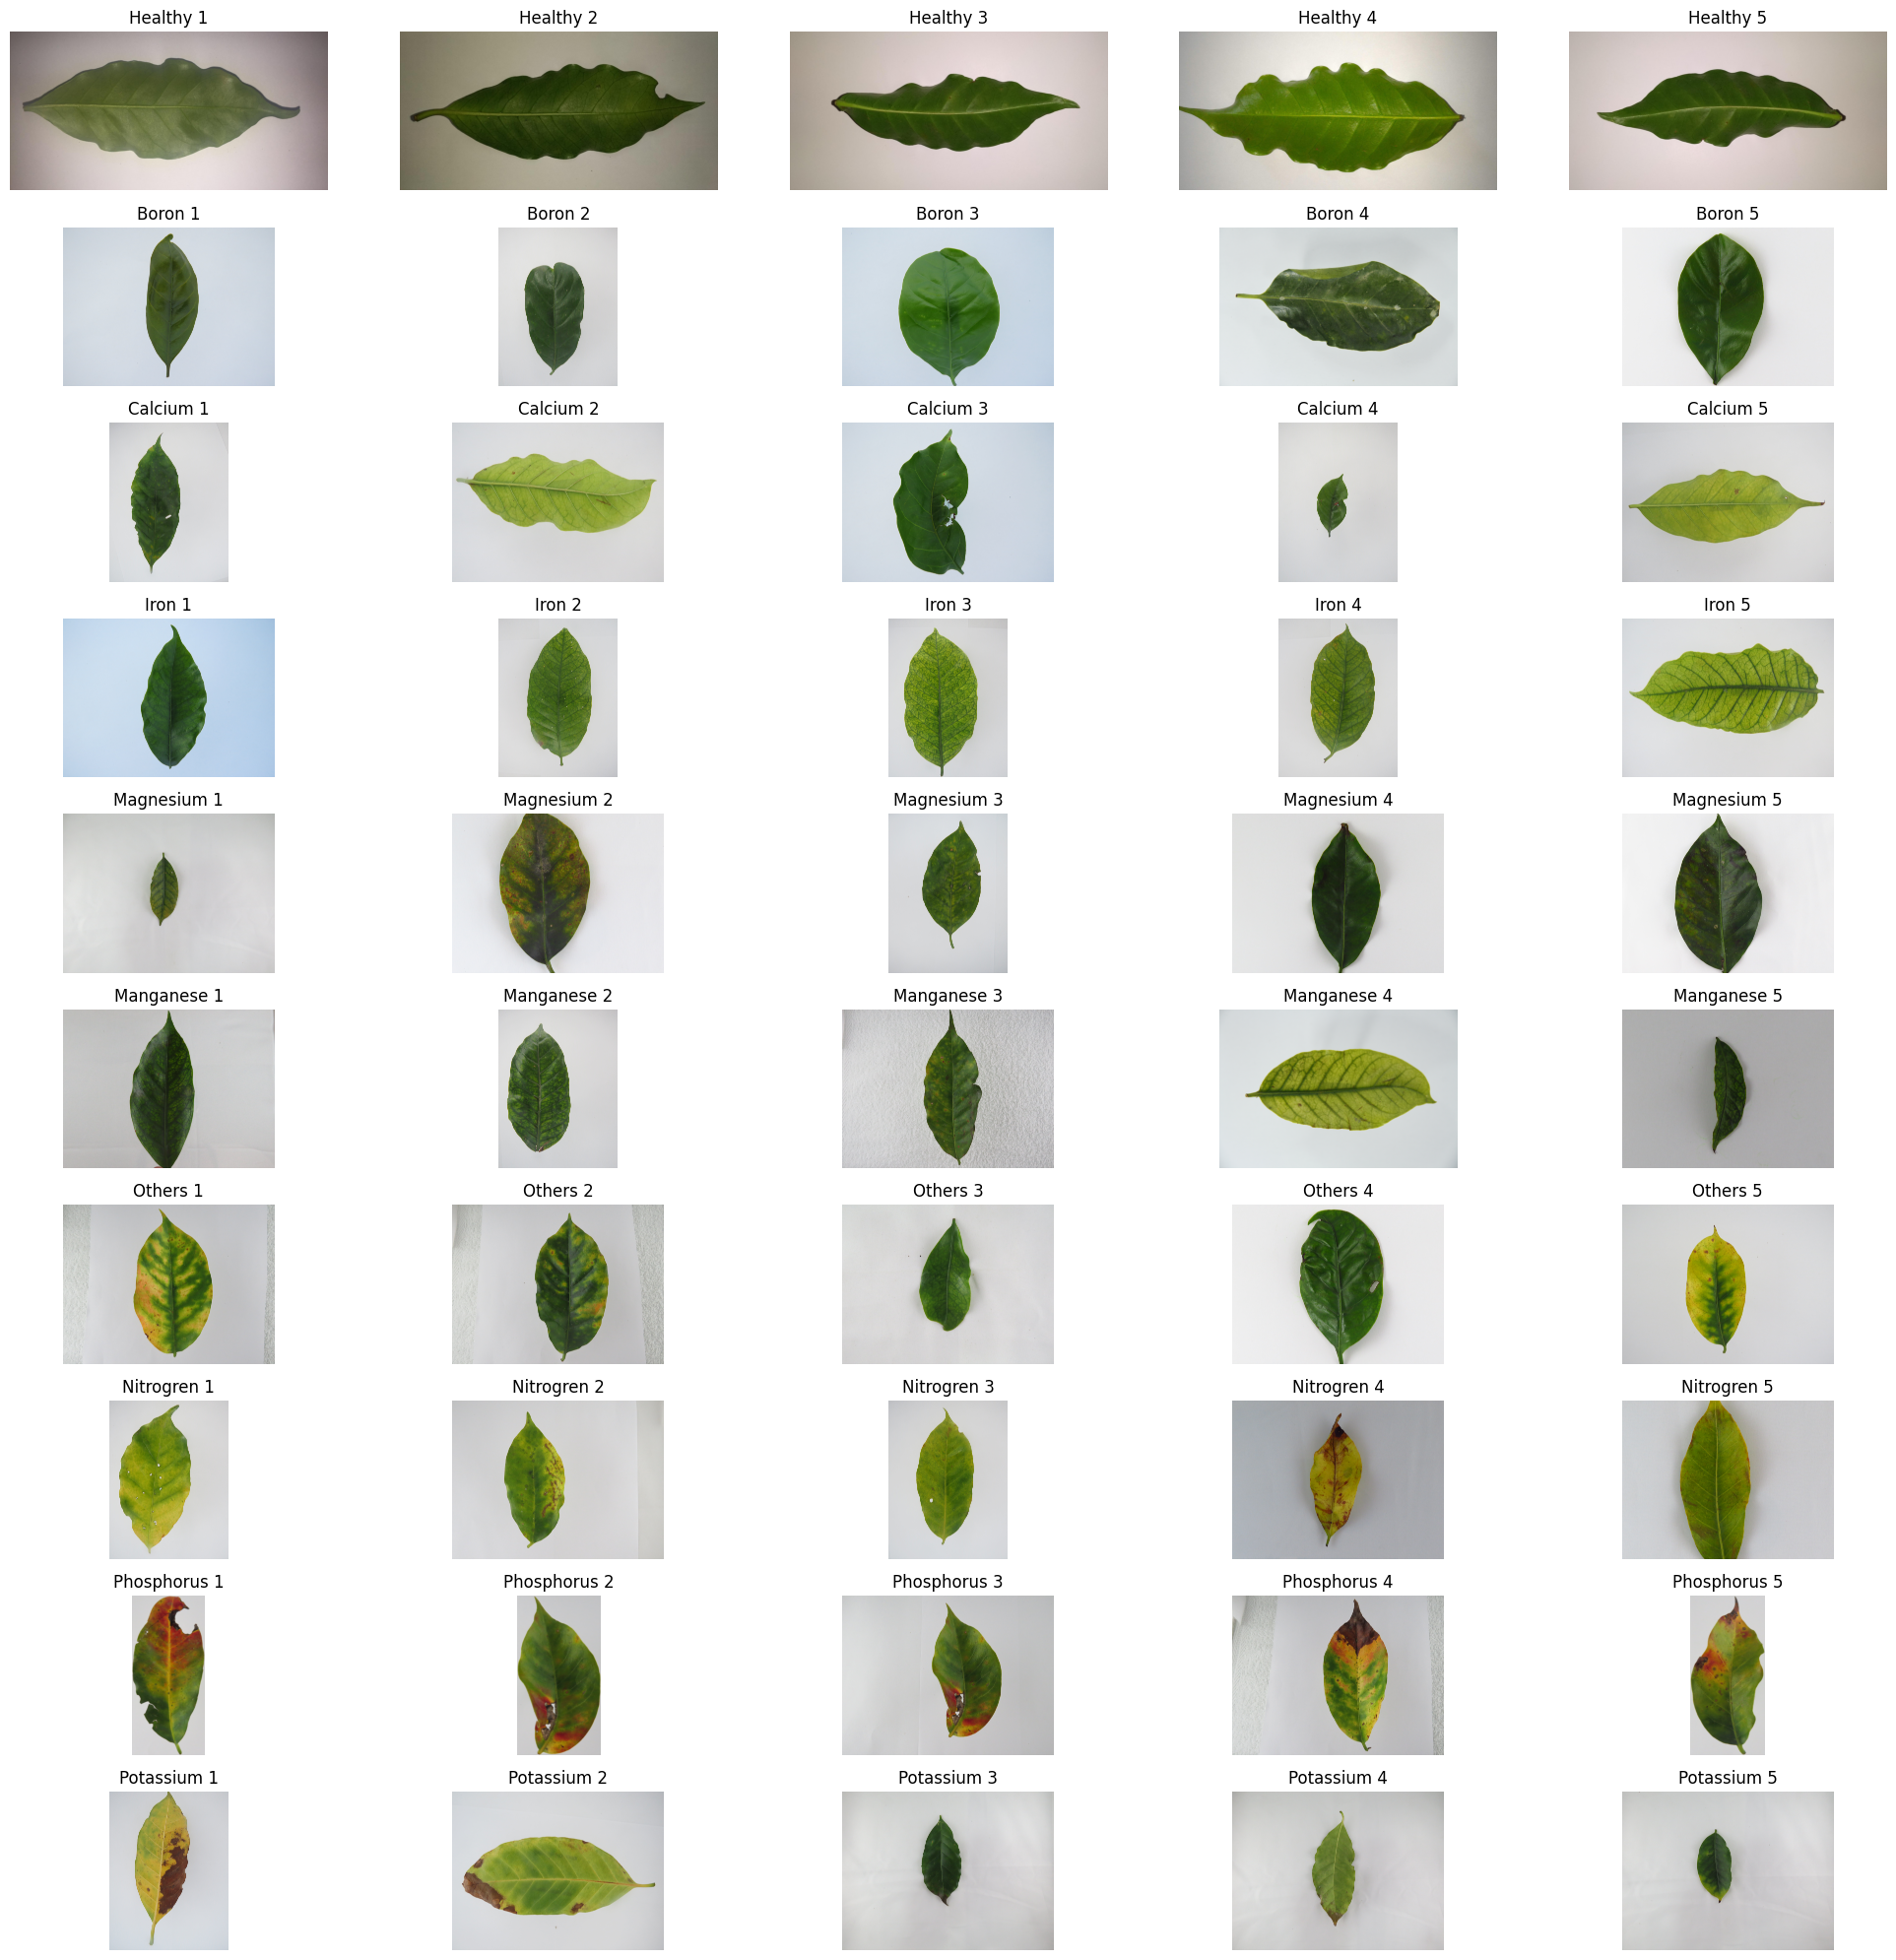

In [ ]:
# Function to display sample images from each category
def display_sample_images(num_images=5):
    category_dict = {
        'Healthy': files_list_dict['healthy'],
        'Boron': files_list_dict['boron'],
        'Calcium': files_list_dict['calcium'],
        'Iron': files_list_dict['iron'],
        'Magnesium': files_list_dict['magnesium'],
        'Manganese': files_list_dict['manganese'],
        'Others': files_list_dict['others'],
        'Nitrogren': files_list_dict['nitrogen'],
        'Phosphorus': files_list_dict['phosphorus'],
        'Potassium': files_list_dict['potasium']
    }

    fig, axes = plt.subplots(len(category_dict), num_images, figsize=(20, 20))

    for row, (category, files) in enumerate(category_dict.items()):
        if files:  # Check if there are any files in the category
            sample_files = files[:num_images]  # Pick the first `num_images` files as samples
            for col, img_path in enumerate(sample_files):
                img = mpimg.imread(img_path)
                axes[row, col].imshow(img)
                axes[row, col].set_title(f'{category} {col+1}')
                axes[row, col].axis('Off')
        else:
            for col in range(num_images):
                axes[row, col].set_title(f'No {category} images')
                axes[row, col].axis('Off')

    plt.tight_layout()
    plt.show()

# Display 5 sample images from each category
display_sample_images(num_images=5)

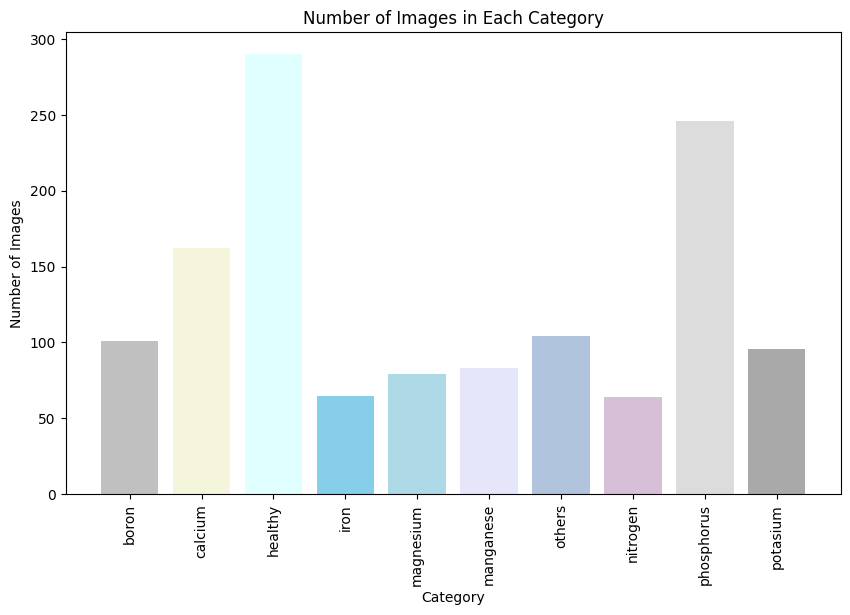

In [ ]:
# Function to display histogram of the number of images in each category
def display_image_count_histogram():
    categories = list(files_list_dict.keys())
    counts = [len(files_list_dict[category]) for category in categories]

    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color=['silver', 'beige', 'lightcyan', 'skyblue', 'lightblue', 'lavender', 'lightsteelblue', 'thistle',
                                       'gainsboro','darkgrey'])
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Category')
    plt.xticks(rotation=90)
    plt.show()

# Display the histogram
display_image_count_histogram()

In [ ]:
import pandas as pd
# Function to display table with the distribution of number of images in each category by train and validation
def display_distribution_table():
    data = {'Category': categories, 'Train': [], 'Validation': [], 'Total': []}

    total_train = 0
    total_validation = 0

    for category in categories:
        train_category_dir = os.path.join(train_dir, category)
        validation_category_dir = os.path.join(validation_dir, category)

        train_count = len(os.listdir(train_category_dir))
        validation_count = len(os.listdir(validation_category_dir))

        total_train += train_count
        total_validation += validation_count

        data['Train'].append(train_count)
        data['Validation'].append(validation_count)
        data['Total'].append(train_count + validation_count)

    data['Category'].append('Total')
    data['Train'].append(total_train)
    data['Validation'].append(total_validation)
    data['Total'].append(total_train + total_validation)

    df = pd.DataFrame(data)
    print(df)

# Display the distribution table
display_distribution_table()

      Category  Train  Validation  Total
0        boron     80          21    101
1      calcium    129          33    162
2      healthy    232          58    290
3         iron     52          13     65
4    magnesium     63          16     79
5    manganese     66          17     83
6       others     83          21    104
7     nitrogen     51          13     64
8   phosphorus    196          50    246
9     potasium     76          20     96
10       Total   1028         262   1290


Augmentation Data

In [ ]:
# Augmentation techniques
augmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range = (0.5, 1.5),
    fill_mode='nearest'
)


# Define paths
dataset_path = '/content/drive/MyDrive/RCP-CNN-1/CoLeaf'
augmented_dataset_path = '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented'

# Ensure the augmented dataset directory exists
if not os.path.exists('/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented'):
    os.makedirs('/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented')

In [ ]:
# Loop through each category
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    augmented_category_path = os.path.join(augmented_dataset_path, category)

    # Check if the category has already been augmented
    if os.path.exists(augmented_category_path) and len(os.listdir(augmented_category_path)) > 0:
        print(f"Category '{category}' already augmented. Skipping...")
        continue

    # Ensure the category directory exists in the augmented dataset
    if not os.path.exists(augmented_category_path):
        os.makedirs(augmented_category_path)

    # Load and augment images
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

        # Generate augmented images
        aug_iter = augmentation.flow(img_array, batch_size=1, save_to_dir=augmented_category_path,
                                     save_prefix='aug_', save_format='jpg')

        # Generate a specific number of augmented images per original image
        for _ in range(10):  # Generate 10 augmented images per original image
            next(aug_iter)

Data Augmentation for `BORO`

In [ ]:
augmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

category = 'boron'
current_images = 2343
required_images = 2536
additional_images_needed = required_images - current_images

# Paths
dataset_path = '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/' + category
augmented_category_path = dataset_path

# Load and augment images
for img_name in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img_name)
    img = load_img(img_path)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

    # Generate augmented images
    aug_iter = augmentation.flow(img_array, batch_size=1, save_to_dir=augmented_category_path,
                                 save_prefix='aug_', save_format='jpg')

    # Generate the required number of additional images
    for _ in range(additional_images_needed):
        next(aug_iter)
        additional_images_needed -= 1
        if additional_images_needed == 0:
            break

Data Augmentation for `CALCIUM`

In [ ]:
augmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

category = 'calcium'
current_images = 2343
required_images = 2543
additional_images_needed = required_images - current_images

# Paths
dataset_path = '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/' + category
augmented_category_path = dataset_path

# Load and augment images
for img_name in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img_name)
    img = load_img(img_path)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

    # Generate augmented images
    aug_iter = augmentation.flow(img_array, batch_size=1, save_to_dir=augmented_category_path,
                                 save_prefix='aug_', save_format='jpg')

    # Generate the required number of additional images
    for _ in range(additional_images_needed):
        next(aug_iter)
        additional_images_needed -= 1
        if additional_images_needed == 0:
            break

Data Augmentation for `IRON`

In [ ]:
augmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

category = 'iron'
current_images = 2203
required_images = 2500
additional_images_needed = required_images - current_images

# Paths
dataset_path = '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/' + category
augmented_category_path = dataset_path

# Load and augment images
for img_name in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img_name)
    img = load_img(img_path)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

    # Generate augmented images
    aug_iter = augmentation.flow(img_array, batch_size=1, save_to_dir=augmented_category_path,
                                 save_prefix='aug_', save_format='jpg')

    # Generate the required number of additional images
    for _ in range(additional_images_needed):
        next(aug_iter)
        additional_images_needed -= 1
        if additional_images_needed == 0:
            break

Data Augmentation `MAGNESIUM`

In [ ]:
augmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

category = 'magnesium'
current_images = 2367
required_images = 2500
additional_images_needed = required_images - current_images

# Paths
dataset_path = '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/' + category
augmented_category_path = dataset_path

# Load and augment images
for img_name in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img_name)
    img = load_img(img_path)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

    # Generate augmented images
    aug_iter = augmentation.flow(img_array, batch_size=1, save_to_dir=augmented_category_path,
                                 save_prefix='aug_', save_format='jpg')

    # Generate the required number of additional images
    for _ in range(additional_images_needed):
        next(aug_iter)
        additional_images_needed -= 1
        if additional_images_needed == 0:
            break

Data Augmentation `MANGANESE`

In [ ]:
augmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

category = 'manganese'
current_images = 2119
required_images = 2500
additional_images_needed = required_images - current_images

# Paths
dataset_path = '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/' + category
augmented_category_path = dataset_path

# Load and augment images
for img_name in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img_name)
    img = load_img(img_path)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

    # Generate augmented images
    aug_iter = augmentation.flow(img_array, batch_size=1, save_to_dir=augmented_category_path,
                                 save_prefix='aug_', save_format='jpg')

    # Generate the required number of additional images
    for _ in range(additional_images_needed):
        next(aug_iter)
        additional_images_needed -= 1
        if additional_images_needed == 0:
            break

Data Augmentation `NITROGEN`

In [ ]:
augmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

category = 'nitrogen'
current_images = 1915
required_images = 2500
additional_images_needed = required_images - current_images

# Paths
dataset_path = '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/' + category
augmented_category_path = dataset_path

# Load and augment images
for img_name in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img_name)
    img = load_img(img_path)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

    # Generate augmented images
    aug_iter = augmentation.flow(img_array, batch_size=1, save_to_dir=augmented_category_path,
                                 save_prefix='aug_', save_format='jpg')

    # Generate the required number of additional images
    for _ in range(additional_images_needed):
        next(aug_iter)
        additional_images_needed -= 1
        if additional_images_needed == 0:
            break

Data Augmentation `PHOSPHORUS`

In [ ]:
augmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

category = 'phosphorus'
current_images = 2281
required_images = 2500
additional_images_needed = required_images - current_images

# Paths
dataset_path = '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/' + category
augmented_category_path = dataset_path

# Load and augment images
for img_name in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img_name)
    img = load_img(img_path)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

    # Generate augmented images
    aug_iter = augmentation.flow(img_array, batch_size=1, save_to_dir=augmented_category_path,
                                 save_prefix='aug_', save_format='jpg')

    # Generate the required number of additional images
    for _ in range(additional_images_needed):
        next(aug_iter)
        additional_images_needed -= 1
        if additional_images_needed == 0:
            break

Data Augmentation `POTASIUM`

In [ ]:
augmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

category = 'potasium'
current_images = 1393
required_images = 2500
additional_images_needed = required_images - current_images

# Paths
dataset_path = '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/' + category
augmented_category_path = dataset_path

# Load and augment images
for img_name in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img_name)
    img = load_img(img_path)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

    # Generate augmented images
    aug_iter = augmentation.flow(img_array, batch_size=1, save_to_dir=augmented_category_path,
                                 save_prefix='aug_', save_format='jpg')

    # Generate the required number of additional images
    for _ in range(additional_images_needed):
        next(aug_iter)
        additional_images_needed -= 1
        if additional_images_needed == 0:
            break

KeyboardInterrupt: 

In [ ]:
# Assuming you have the counts before augmentation
original_counts = {
    'boron': 101,
    'calcium': 162,
    'healthy': 290,
    'iron': 65,
    'magnesium': 79,
    'manganese': 83,
    'others': 104,
    'nitrogen': 64,
    'phosphorus': 246,
    'potasium': 96
}

augmented_counts = {}
for category in os.listdir(augmented_dataset_path):
    augmented_counts[category] = len(os.listdir(os.path.join(augmented_dataset_path, category)))

# Convert to DataFrame for comparison
df = pd.DataFrame([original_counts, augmented_counts], index=['Original', 'Augmented']).T
print(df)

            Original  Augmented
boron            101       2672
calcium          162       2493
healthy          290       2543
iron              65       2428
magnesium         79       2474
manganese         83       2418
others           104       2412
nitrogen          64       2360
phosphorus       246       2446
potasium          96       2475


Data Augmentation `OTHERS`

In [ ]:
augmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

category = 'others'
current_images = 2144
required_images = 2500
additional_images_needed = required_images - current_images

# Paths
dataset_path = '/content/drive/MyDrive/RCP-CNN-1/CoLeaf-augmented/' + category
augmented_category_path = dataset_path

# Load and augment images
for img_name in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img_name)
    img = load_img(img_path)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

    # Generate augmented images
    aug_iter = augmentation.flow(img_array, batch_size=1, save_to_dir=augmented_category_path,
                                 save_prefix='aug_', save_format='jpg')

    # Generate the required number of additional images
    for _ in range(additional_images_needed):
        next(aug_iter)
        additional_images_needed -= 1
        if additional_images_needed == 0:
            break